# Part 1: Improving Fine-tuned Model using RAG

## 1. Download the PDF

PDFs are downloaded once and saved in "pdfs" folder.

To donwload from other url, uncomment the codes below

In [ ]:
# import os
# import requests
# from bs4 import BeautifulSoup

# # URL of the page to scrape (your provided URL)
# url = 'https://www.emaanlibrary.com/book/tafseer-ibn-kathir-in-english-114-surahs-complete/?ebook-category=ruqya&latest=1'

# # Send HTTP request to get the page content
# response = requests.get(url)

# # Parse the HTML content with BeautifulSoup
# soup = BeautifulSoup(response.content, 'html.parser')

# # Find all <a> tags with href links ending in .pdf
# pdf_links = soup.find_all('a', href=True)
# pdf_urls = []

# # Loop through all links and filter out the ones that are PDFs
# for link in pdf_links:
#     href = link['href']
#     if href.endswith('.pdf'):
#         pdf_urls.append(href if 'http' in href else f'https://www.emaanlibrary.com{href}')

# # Create a folder to store downloaded PDFs
# if not os.path.exists('pdfs'):
#     os.makedirs('pdfs')

# # Download each PDF
# for pdf_url in pdf_urls:
#     pdf_name = pdf_url.split("/")[-1]  # Extract the filename from the URL
#     pdf_path = os.path.join('pdfs', pdf_name)

#     # Send request to download the PDF
#     response = requests.get(pdf_url)
    
#     # Write PDF content to a file
#     with open(pdf_path, 'wb') as pdf_file:
#         pdf_file.write(response.content)
    
#     print(f'Downloaded: {pdf_name}')


## 2. Import Library

In [ ]:
# !pip install llama-index
# !pip install llama-index-embeddings-huggingface
# !pip install peft
# !pip install auto-gptq
# !pip install optimum
# !pip install bitsandbytes

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import StorageContext, load_index_from_storage

from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
import torch

from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.is_available()

## 3. Define Llama Index Settings and Vector Database

The Settings is a bundle of commonly used resources used during the indexing and querying stage in a LlamaIndex workflow/application.

https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/settings/

We initially tried Settings.chunk_size = 120 and Settings.chunk_overlap = 20. However, this process lead to different number of token accross different documents. 

We then tried token based chunking. https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/

import any embedding model on HF hub (https://huggingface.co/spaces/mteb/leaderboard)

In [ ]:
# import any embedding model on HF hub (https://huggingface.co/spaces/mteb/leaderboard)

# 384 dimension
# Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"") # alternative model

# ---- SETUP ----
# Embedding model config
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
Settings.embed_model = HuggingFaceEmbedding(
    model_name=model_name,
    show_progress_bar=True
)

Settings.llm = None
# Tokenizer 
embed_tokenizer = AutoTokenizer.from_pretrained(model_name)

Settings.chunk_size = 128
Settings.chunk_overlap = 32

## 4. Read Preprocess data

SimpleDirectoryReader is the simplest way to load data from local files into LlamaIndex. For production use cases it's more likely that you'll want to use one of the many Readers available on LlamaHub, but SimpleDirectoryReader is a great way to get started. 
https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader/

tqdm is used to tract progress
 
 ### Sample Page of Tafsir
 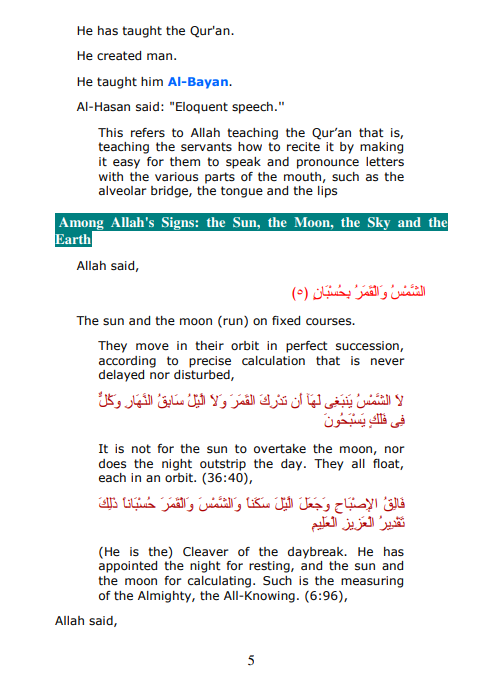 
 ### Sample page of a Hadith
 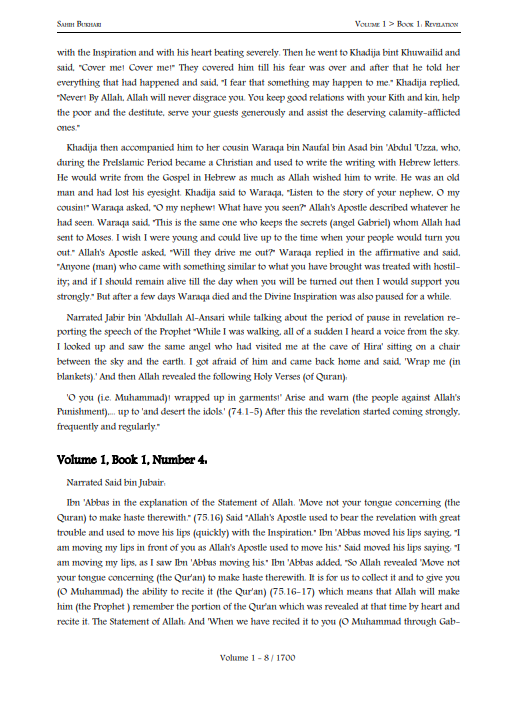 

From the above we can see that the 114 tafsir dosuments we used have less words per page compared to the words count of two Hadith documents we are going to embed.

### 4.1 Load documents using SimpleDirectoryReader
We fill first embed the documents using chunk size of 256 with 32 overlapping.  These numbers are chosen after several trials and errors.

In [ ]:
from tqdm import tqdm 
from time import perf_counter as timer
start_time = timer()

reader = SimpleDirectoryReader(
             input_dir = "pdfs", 
             # exclude=["en_Sahih_Al-Bukhari.pdf", "en_Sahih_Muslim.pdf"],
             recursive = False)
documents = []
for docs in tqdm(reader.iter_data()):
    documents.extend(docs)

end_time = timer()
print(f"[INFO] Time taken: {end_time-start_time:.5f} seconds.")

### 4.2 Use sentencizer 
A better way to chunk documents is to create sentences using Natural language and later join them together to get the context. This process ensures that during chunking the sentences aren’t separated—they're all jumbled together.

In [ ]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

### 4.3 Extract relevant info from loaded documents
We will create chunk and extract information from each chunk.

In [ ]:
docs = []
for ii in tqdm(range(len(documents))):
    file_name = documents[ii].metadata['file_name']
    page = documents[ii].metadata['page_label']
    content = documents[ii].text.replace('\n', '').replace('  ', ' ').replace('\'', '').replace('...', '.')
    sentences = [str(sent) for sent in list(nlp(content).sents)]
    page_characters = len(content)
    page_tokens = len(embed_tokenizer.encode(content, truncation=False))
    
    docs.append(
        {"file_name": file_name,
         "page": page,
         "content":content,
         "sentences":sentences,
         "chunk_characters": page_characters,
         "chunk_tokens": page_tokens}
    )

In [ ]:
import random 
random.sample(docs, 3)

### 4.4 Create Pandas dataframe

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame(docs)
df.tail(10)

In [ ]:
df.describe()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df["chunk_tokens"], color='k', label="Token Count per Chunk")
plt.axhline(df['chunk_tokens'].mean(), color='red', linestyle='--', label='Mean Token Count')
plt.xlabel("Chunk Index")
plt.ylabel("Number of Tokens per Chunk")
plt.legend()
plt.grid(False)
plt.show()

### Note
We can see that the token size in these last documents are higher than the LLM model can handle. 
Therefore, we will procee the data using manual sentence chunking.

We created sentences in our dataframe so that we can use manual chunking procedure.

## 5. Manual Chunking of Documents
We created sentences in our dataframe so that we can use manual chunking procedure.

In [ ]:
import re
def create_chunk(docs, slice_size=10):
    docs_and_chunks = []
    for item in tqdm(docs, desc="Creating Chunks"):
        sentence_chunks = [item["sentences"][i:i + slice_size]
                           for i in range(0, len(item["sentences"]), slice_size)]
        
        item["sentence_chunks"] = str(sentence_chunks)
        item["num_chunks"] = len(sentence_chunks)

        for sentence_chunk in sentence_chunks:
            chunk_text = re.sub(r'\.([A-Z])', r'. \1', " ".join(sentence_chunk).strip())
            page_tokens = len(embed_tokenizer.encode(chunk_text, truncation=False))
            chunk_dict = {
                "document_name": item["file_name"],
                "page_number": item["page"],
                "sentence_chunk": chunk_text,
                "chunk_char_count": len(chunk_text),
                "chunk_word_count": len(chunk_text.split()),
                "chunk_token_count": page_tokens
            }

            docs_and_chunks.append(chunk_dict)

    return docs_and_chunks

In [ ]:
chunked_docs = create_chunk(docs, slice_size=10)

In [ ]:
random.sample(chunked_docs, 2)

In [ ]:
chunked_df = pd.DataFrame(chunked_docs)
chunked_df.tail()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(chunked_df.index, chunked_df["chunk_token_count"], color='k', label="Token Count per Chunk")
plt.axhline(chunked_df['chunk_token_count'].mean(), color='red', linestyle='--', label='Mean Token Count')
plt.xlabel("Chunk Index")
plt.ylabel("Number of Tokens per Chunk")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
chunked_df.describe()

### 5.1 Data filtration
Some of the chunked has very minimal token. We fill remove those from dataset

In [ ]:
min_token_df = chunked_df[chunked_df["chunk_token_count"] < 7]
print(len(min_token_df))

min_token_df

In [ ]:
import pandas as pd

def filter_min_tokens(df, min_tokens=7):
    return df[df["chunk_token_count"] >= min_tokens].reset_index(drop=True)

filtered_df = filter_min_tokens(chunked_df, min_tokens= 7)

In [ ]:
filtered_df.head()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df["chunk_token_count"], color='k', label="Token Count per Chunk")
plt.axhline(filtered_df['chunk_token_count'].mean(), color='red', linestyle='--', label='Mean Token Count')
plt.xlabel("Chunk Index")
plt.ylabel("Number of Tokens per Chunk")
plt.legend()
plt.grid(False)
plt.show()

### 5.2 Saving the chunked dataframe for re-use

In [ ]:
# Save the DataFrame
filtered_df.to_csv('./pdfs/filtered_df.csv', index=False)

## 6. Vector Store Index

An Index is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for retrieval-augmented generation (RAG) use-cases.
Vector Stores are a key component of retrieval-augmented generation (RAG) and so you will end up using them in nearly every application you make using LlamaIndex, either directly or indirectly.
https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores/

In [ ]:
# Loading saved dataframe
filtered_df = pd.read_csv("./pdfs/filtered_df.csv")
filtered_df.head()

### 6.1 Creating LlamaIndex Document

In [ ]:
from llama_index.core.schema import Document
import os
print(os.getcwd())

filtered_documents = [
    Document(
        text=row["sentence_chunk"],
        metadata={
            "document_name": row["document_name"],
            "page_number": row["page_number"],
            "chunk_char_count": row["chunk_char_count"],
            "chunk_word_count": row["chunk_word_count"],
            "chunk_token_count": row["chunk_token_count"]
        }
    )
    for _, row in filtered_df.iterrows()
]

In [ ]:
filtered_documents[:1]

### 6.2 Store data in faiss Store Index
https://docs.llamaindex.ai/en/stable/examples/vector_stores/FaissIndexDemo/

In [ ]:
import faiss

# dimensions of text-ada-embedding-002
# https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2
d = 768
faiss_index = faiss.IndexFlatL2(d)

In [ ]:
from llama_index.core import (
    SimpleDirectoryReader,
    load_index_from_storage,
    VectorStoreIndex,
    StorageContext,
)
from llama_index.vector_stores.faiss import FaissVectorStore
from IPython.display import Markdown, display

In [ ]:
vector_store = FaissVectorStore(faiss_index=faiss_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    filtered_documents, storage_context=storage_context
)

In [ ]:
# save index to disk
index.storage_context.persist(persist_dir="pdfs/faiss_db")

## 7. Reload Saved Documents

In [ ]:
import faiss

# Reload the same embedding model
model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
Settings.embed_model = HuggingFaceEmbedding(model_name=model_name)

# load index from disk
vector_store = FaissVectorStore.from_persist_dir("pdfs/faiss_db")
storage_context = StorageContext.from_defaults(
    vector_store=vector_store, persist_dir="pdfs/faiss_db"
)
index = load_index_from_storage(storage_context=storage_context)

### 7.1 Set Up Search Function

In [ ]:
# set number of docs to retreive
top_k = 5

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=top_k,
)

In [ ]:
# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.4)],
)

### 7.2 Example: Retrieve Relevant Docs

In [ ]:
manual_questions = ["What is the minimum amount of wealth a person need to own to pay Jakat",
                    "When did battle of badr occured?",
                    "Who will enter the paradise first?"
]

query_list = manual_questions

# query documents
query = query_list[0]
response = query_engine.query(query)

In [ ]:
# reformat response
context = "Context:\n"
top_k = min(top_k, len(response.source_nodes))  # avoid index overflow

for i in range(top_k):
    node = response.source_nodes[i].node  # Get the actual node object
    text = node.text
    metadata = node.metadata  # This is a dictionary

    context += f"--- Source {i+1} ---\n"
    context += f"Text: {text}\n"
    context += f"Metadata: {metadata}\n\n"

print(context)

## 8. Import LLM for generating answer

Now we will use a Large Language Model to generate answer using user query with/without context retrieved from our Vector Store.

In [ ]:
# Run the following to empty the VRAM:
import gc
import torch
# del model, tokenizer, pipe

# Flush memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# load fine-tuned model from hub
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"

model_name = "Qwen/Qwen2.5-3B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

### 8.1 Check the model size and memory requirements

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model)

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(model)

## 9. Text Generation using LLM

In [ ]:
# List of queries
manual_questions = ["Who are the people bound to pay Jakat?",
                    "When did battle of badr occured?",
                    "Name the person who will enter the paradise first?",
                    
]
chat_gpt = [
    "What rights does Islam grant to women regarding property and inheritance?",
    "Are women allowed to seek education in Islam?",
    "Can women work and earn a living in Islam?",
    "Do women have the right to choose their spouse in Islam?",
    "What is the Islamic stance on domestic violence?",
    "Are men and women equal in spiritual matters in Islam?",
    "Do women have the right to participate in public and political life in Islam?",
    "What does Islam say about women's dress code?",
    "Can women lead prayers in Islam?",
    "How does Islam address the issue of gender equality?"
]

query_list = manual_questions + chat_gpt

### 9.1 Text generation without context

In [ ]:
model.eval()

# Choose query index 4 (number --5) from the query list
query = query_list[4]

# Created a prompt template
base_prompt = f"""
    Provide a concise answer based on the Quran, tafsir, and hadith.
    Do not include the reasoning, just the answer. Make sure the answer is factually correct based on islamic 
    faith.
    \n{query}
"""

# Create prompt template for instruction-tuned model
dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(
                         **input_ids,
                         do_sample=True,
                         temperature = 0.7,
                         max_new_tokens = 256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(output_text)

### 9.2 Text generation with context (RAG)

In [ ]:
# query documents
query = query_list[4]
response = query_engine.query(query)

# container for all document info
doc_info = []

top_k = min(top_k, len(response.source_nodes))

for i in range(top_k):
    node = response.source_nodes[i].node
    text = node.text
    metadata = node.metadata

    file_name = metadata.get('document_name', f'doc_{i}').replace('.pdf', '')
    page = str(metadata.get('page_number', 'unknown'))
    score = round(response.source_nodes[i].score, 4)

    doc_info.append({
        "score": score,
        "content": text.strip(),
        "page": page,
        "file_name": file_name
    })

# sort by ascending similarity score
doc_info = sorted(doc_info, key=lambda x: x["score"], reverse=True)

# now extract individual fields
scores = [str(item["score"]) for item in doc_info]
contents = [item["content"] for item in doc_info]
pages = [item["page"] for item in doc_info]
file_names = [item["file_name"] for item in doc_info]

# final context dictionary
context = {
    "scores": ', '.join(scores),
    "content": "\n".join(contents),
    "page": ', '.join(pages),
    "file_name": ', '.join(file_names)
}

# print
print(context)

In [ ]:
model.eval()

query = query_list[4]

base_prompt = f"""
    Please see and following context given below.
    \n{context['content']}
    Answer the following query based on Quran, tafsir and hadith of Islamic faith. 
    Don't return the thinking, only return the answer.
    Make sure your answers are as concise as possible and factually correct based on islamic faith.
    \n{query}
     
"""
# Create prompt template for instruction-tuned model
dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(
                         **input_ids,
                         do_sample=True,
                         temperature = 0.7,
                         max_new_tokens = 256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(output_text)

# Part 2: Evaluation of RAG
Well, our LLM and Retrieval system is working. Next step is to evaluate the results. 

### see this blog about LaaJ: https://arize.com/blog-course/llm-as-a-judge/
How can LLM-as-a-Judge be used for RAG Applications?

Contextual relevance and faithfulness are two of the most widely-used metrics for assessing the accuracy and relevance of retrieved files of documents when leveraging LLM RAG.

## 1. Evaluation of LLM results without RAG

In [ ]:
# List of queries
manual_questions = ["Who are the people bound to pay Jakat?",
                    "When did battle of badr occured?",
                    "Name the person who will enter the paradise first?",
                    
]
chat_gpt = [
    "What rights does Islam grant to women regarding property and inheritance?",
    "Are women allowed to seek education in Islam?",
    "Can women work and earn a living in Islam?",
    "Do women have the right to choose their spouse in Islam?",
    "What is the Islamic stance on domestic violence?",
    "Are men and women equal in spiritual matters in Islam?",
    "Do women have the right to participate in public and political life in Islam?",
    "What does Islam say about women's dress code?",
    "Can women lead prayers in Islam?",
    "How does Islam address the issue of gender equality?"
]

query_list = manual_questions + chat_gpt

In [ ]:
## Generate a dataframe for all the queries from query_list

# A dataframe to store query, answer, hyperparameters, and Rating
eval_df = []

# Hyperparameters
temperature = 0.6  
max_new_tokens = 256

for ii in range(len(query_list)):
    query = query_list[ii]
    
    base_prompt = f"""
        Provide a concise answer based on the Quran, tafsir, and hadith.
        Do not include the reasoning, just the answer. Make sure the answer is factually correct based on islamic 
    faith.
        \n{query}
    """

    # Create prompt template for instruction-tuned model
    dialogue_template = [
            {"role": "user",
            "content": base_prompt}
        ]
    
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                              tokenize=False,
                                              add_generation_prompt=True)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    prompt_len = input_ids['input_ids'].shape[-1]  # Length of the prompt
    
    outputs = model.generate(
                             **input_ids,
                             do_sample=True,
                             temperature = temperature,
                             max_new_tokens = max_new_tokens)
    
    # Extract only the generated tokens (ignoring the context and prompt part)
    generated_tokens = outputs[0][prompt_len:]
    
    # Decode the generated response
    output_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    eval_df.append({
        "query": query,
        "answer": output_text.replace('<|im_end|>', '').replace('<|im_start|>', ''),
        "temperature": temperature,
        "max_new_tokens":max_new_tokens
    })

In [ ]:
eval_df = pd.DataFrame(eval_df)
eval_df

In [ ]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show full width of each column
pd.set_option('display.max_colwidth', None)

# Now print the selected columns
# print(eval_df[['query', 'answer']])


In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [ ]:
### Chatgpt 3.5 rating

In [ ]:
import pandas as pd

# Data
data = {
    "Query": [
        "Who are the people bound to pay Jakat?",
        "When did battle of badr occured?",
        "Name the person who will enter the paradise first?",
        "What rights does Islam grant to women regarding property and inheritance?",
        "Are women allowed to seek education in Islam?",
        "Can women work and earn a living in Islam?",
        "Do women have the right to choose their spouse in Islam?",
        "What is the Islamic stance on domestic violence?",
        "Are men and women equal in spiritual matters in Islam?",
        "Do women have the right to participate in public and political life in Islam?",
        "What does Islam say about women's dress code?",
        "Can women lead prayers in Islam?",
        "How does Islam address the issue of gender equality?"
    ],
    "Answer": [
        "The people who are bound to pay Zakat (charity) are those who have wealth exceeding the Nisab threshold and meet other conditions specified in the Quran and Sunnah. Specifically, it includes free adult Muslims who are not exempted due to illness, travel, or old age, and who own more than the Nisab of gold or silver.",
        "The Battle of Badr occurred in the second year after the migration from Mecca to Medina (624 CE).",
        "The person who will enter Paradise first is Maryam (Mary).",
        "In Islam, women have rights to inherit from their families, and they receive a share of the estate that is generally one-half of what is given to a man. However, specific shares can vary based on the legal interpretations and may be influenced by local customs. Women also have rights over their own property and can manage it as per their discretion.",
        "Yes, women are allowed to seek education in Islam.",
        "Yes, according to Islamic teachings as interpreted through the Quran, Tafsir, and Hadith, women can work and earn a living.",
        "Yes, women have the right to choose their spouse in Islam, but it ultimately depends on the consent of their guardians as per Islamic law.",
        "The Islamic stance on domestic violence is unequivocally against it. According to the Quran and Hadith, a husband is not permitted to beat his wife; instead, he should treat her with kindness and respect.",
        "In Islam, men and women are considered equal spiritually, as they both have an important role in worship and are equally responsible before Allah.",
        "Yes, women have the right to participate in public and political life in Islam, as evidenced by various verses in the Quran and narrations from the Prophet Muhammad (PBUH).",
        "Islam does not prescribe a specific dress code for women, but it emphasizes modesty and privacy. Women are encouraged to dress in a way that covers their awrah (parts of the body that must be concealed) and avoids displaying adornment unnecessarily. The primary focus is on maintaining dignity and respect.",
        "No, women are not allowed to lead prayers in Islam according to the Quran, tafsir, and hadith.",
        "Islam addresses the issue of gender equality through various teachings in the Quran, Sunnah, and Hadith, emphasizing that all humans are equal before Allah without distinction of gender, race, or social status. Women are encouraged to pray, fast, give charity, and seek knowledge. They are also commanded to maintain modesty and chastity. However, men and women have different roles and responsibilities within marriage, with men being primarily responsible for providing financially and maintaining the household. Women's testimony in legal matters is considered equal to men's. Overall, Islam promotes equity rather than equality, recognizing inherent differences while ensuring fair treatment and respect for both genders."
    ],
    "Rating": [
        "Good", "Good", "Bad", "Okay", "Good", "Good", "Okay", "Okay", "Good", "Good", "Okay", "Okay", "Okay"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df.head(13)  # Display all 13 rows



## 2. Evaluation of LLM results with RAG

In [ ]:
# List of queries
manual_questions = ["Who are the people bound to pay Jakat?",
                    "When did battle of badr occured?",
                    "Name the person who will enter the paradise first?",
                    
]
chat_gpt = [
    "What rights does Islam grant to women regarding property and inheritance?",
    "Are women allowed to seek education in Islam?",
    "Can women work and earn a living in Islam?",
    "Do women have the right to choose their spouse in Islam?",
    "What is the Islamic stance on domestic violence?",
    "Are men and women equal in spiritual matters in Islam?",
    "Do women have the right to participate in public and political life in Islam?",
    "What does Islam say about women's dress code?",
    "Can women lead prayers in Islam?",
    "How does Islam address the issue of gender equality?"
]

query_list = manual_questions + chat_gpt

In [ ]:
## Generate a dataframe for all the queries from query_list

# A dataframe to store query, answer, hyperparameters, and Rating
eval_df = []

# Hyperparameters
temperature = 0.6
max_new_tokens = 256

top_k = 5

for ii in range(len(query_list)):
    query = query_list[ii]
    response = query_engine.query(query)

    # container for all document info
    doc_info = []
    
    top_k = min(top_k, len(response.source_nodes))
    
    for i in range(top_k):
        node = response.source_nodes[i].node
        text = node.text
        metadata = node.metadata
    
        file_name = metadata.get('document_name', f'doc_{i}').replace('.pdf', '')
        page = str(metadata.get('page_number', 'unknown'))
        score = round(response.source_nodes[i].score, 4)
    
        doc_info.append({
            "score": score,
            "content": text.strip(),
            "page": page,
            "file_name": file_name
        })
    
    # sort by ascending similarity score
    doc_info = sorted(doc_info, key=lambda x: x["score"], reverse=True)
    
    # now extract individual fields
    scores = [str(item["score"]) for item in doc_info]
    contents = [item["content"] for item in doc_info]
    pages = [item["page"] for item in doc_info]
    file_names = [item["file_name"] for item in doc_info]
    
    # final context dictionary
    context = {
        "scores": ', '.join(scores),
        "content": "\n".join(contents),
        "page": ', '.join(pages),
        "file_name": ', '.join(file_names)
    }
    
    base_prompt = f"""
        You are an expert in Islamic knowledge, specializing in the Quran, authentic Hadith, classical Tafsir, 
        and Islamic history. Answer the question supported from the context below. Be concise, accurate, and factual. 
        Avoid speculation, reasoning, or unsupported generalities. 
        Focus on clarity, authenticity, and relevance and be concise in answering.
        
        Context:
        {context['content']}
        Question:
        {query}
        Answer:
        """



    # Create prompt template for instruction-tuned model
    dialogue_template = [
            {"role": "user",
            "content": base_prompt}
        ]
    
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                              tokenize=False,
                                              add_generation_prompt=True)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    prompt_len = input_ids['input_ids'].shape[-1]  # Length of the prompt
    
    outputs = model.generate(
                             **input_ids,
                             do_sample=True,
                             temperature = temperature,
                             max_new_tokens = max_new_tokens)
    
    # Extract only the generated tokens (ignoring the context and prompt part)
    generated_tokens = outputs[0][prompt_len:]
    
    # Decode the generated response
    output_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    eval_df.append({
        "query": query,
        "answer": output_text.replace('<|im_end|>', '').replace('<|im_start|>', ''),
        "temperature": temperature,
        "max_new_tokens":max_new_tokens,
        "context_items": context['content'],
        "scores":context['scores'],
        "document": context['file_name'], 
        "page_number": context['page']
    })

In [ ]:
eval_df = pd.DataFrame(eval_df)
# eval_df

In [ ]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show full width of each column
pd.set_option('display.max_colwidth', None)

# Now print the selected columns
# print(eval_df[['query', 'answer']])

In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

###  Evaluation results with chatgpt3.5